In [1]:
%load_ext autoreload
%autoreload 2
%cd ..

/Users/massil/repos/newsvendor_tester


In [2]:
import pandas as pd
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt

from environment import *
from algorithms.cup import CUP_algorithm
from algorithms.rcosd_adaptive_box import RCOSD_Adaptive_Box_algorithm
from algorithms.cosd_adaptive_box import COSD_Adaptive_Box_algorithm
from simulator import Simulator

from tqdm import tqdm

### Defining the demand process
Here we define a perishable environment such that $n=1$, $T=2000$ and $d_t= \text{round}(Z^+)$ where $Z\sim\mathcal{N}(1,1)$ and $\text{round}$ , with losses $\ell_t(y) = |y-d_t|$.

Notice that in this example $\rho=1$

In [3]:
nb_products = 1
horizon = 2_000

def env_generator() :
    demands = np.zeros((horizon+1,nb_products))
    demands[1:,:] = np.round(np.maximum(0,scipy.stats.norm(loc=1).rvs(size=(horizon, nb_products))))
    return Environment_Perishable_L1(2, demands)

Plotting a demand realizations and histogram

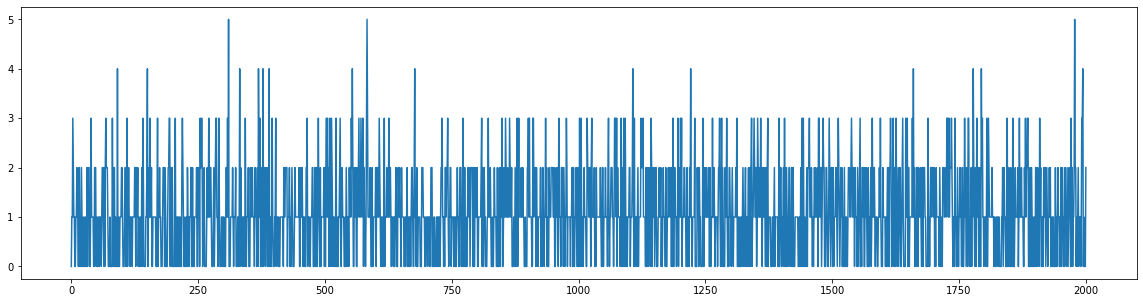

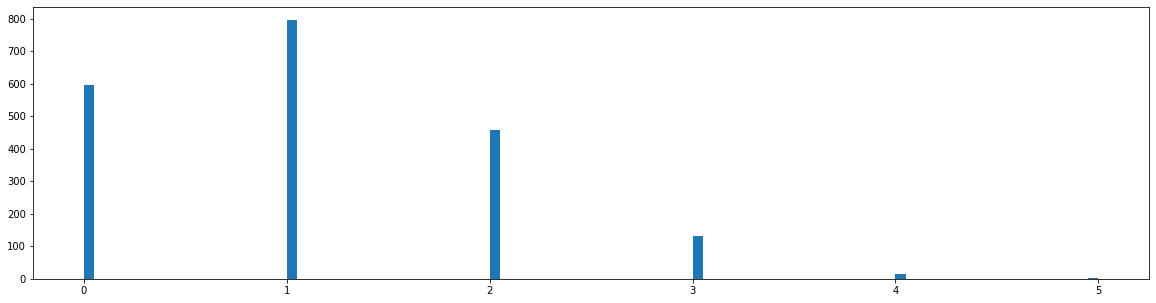

In [4]:
demands_example = env_generator().demands
plt.figure(figsize=(20,5))
plt.plot(demands_example)
plt.show()
plt.figure(figsize=(20,5))
plt.hist(demands_example,bins=100)
plt.show()

### Defining the algorithms

The box constraint, the hyperparameter $\gamma\leq \rho/D$ and the gradients' norm upper bound $G$

In [5]:
y_min = 0*np.ones(nb_products)
y_max = 2*np.ones(nb_products)
gamma = 1/np.sqrt(np.sum((y_max-y_min)*(y_max-y_min)))
G = np.sqrt(nb_products)*1.

The algorithms

In [6]:
nb_algs = 3
initial_decision = 2*np.ones(nb_products)
algs = [
    CUP_algorithm(initial_decision, y_min,y_max, gamma, G),
    COSD_Adaptive_Box_algorithm(initial_decision,y_min,y_max,gamma),
    RCOSD_Adaptive_Box_algorithm(initial_decision,y_min,y_max,gamma)
]

Building the simulator which wraps the main loop

In [7]:
nb_samples = 10
horizons = np.linspace(50,horizon,100).astype(int)

sim = Simulator(env_generator, nb_products, nb_samples, horizons, algs,
    lambda optimum : ((optimum>=y_min).all() and (optimum<=y_max).all()))
cum_losses = sim.run()

100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


In [8]:
for i in range(nb_algs) :
    print("Alg {} ({}) final regret: {}, final regret std: {}".format(
        i,
        algs[i],
        np.mean((cum_losses[:,i+1,-1]-cum_losses[:,0,-1])),
        np.std(cum_losses[:,i+1,-1]-cum_losses[:,0,-1])
        #np.std(np.sum(losses[:,i+1,:],axis=1)-np.sum(losses[:,0,:],axis=1))
    ))

Alg 0 (CUP $\gamma=0.5$) final regret: 87.79445467581957, final regret std: 7.126580980080323
Alg 1 (COSD $\gamma=0.5$) final regret: 44.11106267181928, final regret std: 1.765766270866985
Alg 2 (RCOSD_Adaptive_Box $\gamma=0.5$) final regret: 43.930345000131936, final regret std: 1.6840840325868773


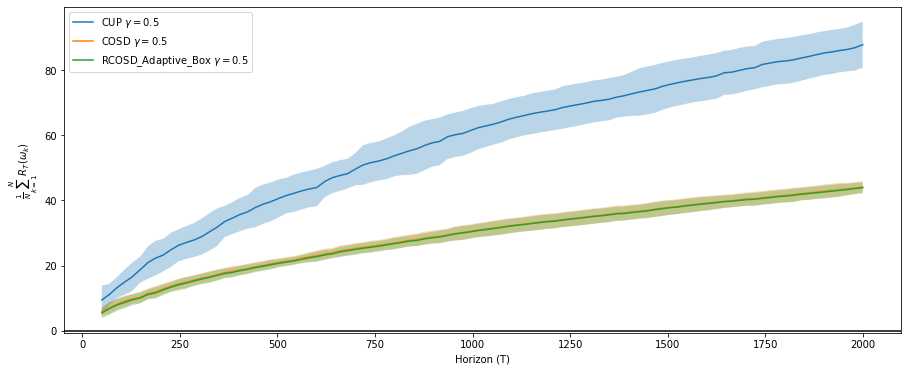

In [9]:
plt.figure(figsize=(15,6))
for i in range(nb_algs) :
    y = np.mean(cum_losses[:,i+1,:]-cum_losses[:,0,:],axis=0)
    std = np.std(cum_losses[:,i+1,:]-cum_losses[:,0,:],axis=0)
    plt.plot(horizons, y,label=algs[i])
    plt.fill_between(horizons, y-std,y+std,alpha=0.3)
plt.axhline(0,color="k")
#plt.plot(horizons,np.sqrt(horizons)*D/2*np.sqrt(2/np.pi),"--",color="k",label="theoretical equivalent")
#plt.plot(horizons,np.sqrt(horizons)*D/(4*np.sqrt(2)),"x",color="k",label="theoretical lower bound")
plt.ylabel(r"$\frac{1}{N}\sum_{k=1}^N R_T(\omega_k)$")
plt.xlabel("Horizon (T)")
plt.legend()
plt.show()

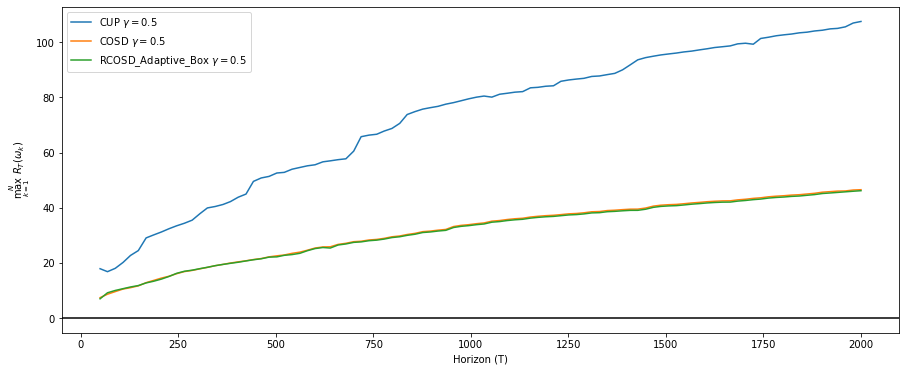

In [10]:
plt.figure(figsize=(15,6))
for i in range(nb_algs) :
    plt.plot(horizons, np.max(cum_losses[:,i+1,:]-cum_losses[:,0,:],axis=0),label=algs[i])
plt.axhline(0,color="k")
#plt.plot(horizons,(1/(2*gamma_1/20)+gamma_1/20)*D*G*np.sqrt(horizons),"--",color="blue",label="regret upper bound for gamma={}".format(gamma_1/20))
#plt.plot(horizons,(1/(2*gamma_1/5)+gamma_1/5)*D*G*np.sqrt(horizons),"--",color="orange",label="regret upper bound for gamma={}".format(gamma_1/5))
#plt.plot(horizons,(1/(2*gamma_1)+gamma_1)*D*G*np.sqrt(horizons),"--",color="green",label="regret upper bound for gamma={}".format(gamma_1))
plt.ylabel(r"$\max_{k=1}^N \ R_T(\omega_k)$")
plt.xlabel("Horizon (T)")
plt.legend()
plt.show()